In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, Adadelta, SGD
from torch.profiler import profile, record_function, ProfilerActivity

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader import ImageSuperResolution
import model_MMGLR as model_structure




In [2]:

LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test09/logs/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'training00.log'), 
    level=logging.INFO
)

CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test09/checkpoints/")
VERBOSE_RATE = 1000

(H_train, W_train) = (128, 128)
(H_val, W_val) = (128, 128)
(H_test, W_test) = (496, 496)

train_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/DFWB_training_data_info.csv"),
    dist_mode="addictive_noise_scale",
    lambda_noise=25.0,
    patch_size=H_train,
    patch_overlap_size=H_train//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

validation_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/CBSD68_testing_data_info.csv"),
    dist_mode="addictive_noise_scale",
    lambda_noise=25.0,
    patch_size=H_val,
    patch_overlap_size=H_train//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)

test_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv"),
    dist_mode="addictive_noise_scale",
    lambda_noise=25.0,
    patch_size=H_test,
    patch_overlap_size=H_train//2,
    max_num_patchs=1000000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)


data_train_batched = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, num_workers=4
)

data_valid_batched = torch.utils.data.DataLoader(
    validation_dataset, batch_size=16, num_workers=4
)

data_test_batched = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=4
)

In [ ]:
# training_state_path = os.path.join(CHECKPOINT_DIR, 'checkpoints_epoch00_iter0119k.pt')
# training_state = torch.load(training_state_path)

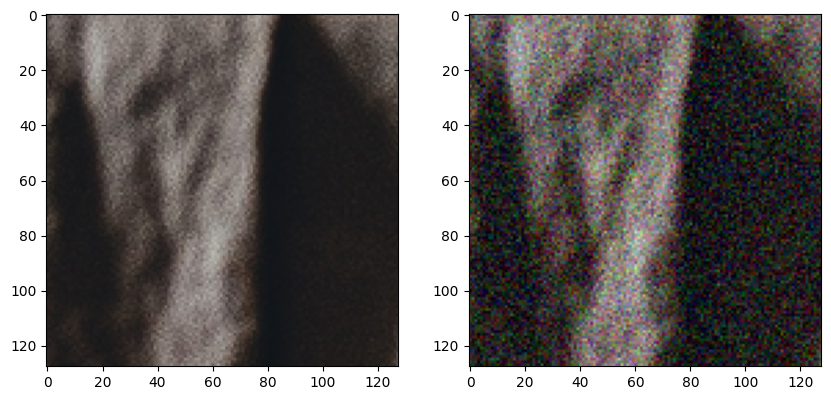

In [3]:

for patchs_noisy, patchs_true in data_train_batched:
    break
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hh, ww = (496, 496)
axs[0].imshow((patchs_true[0][:hh, :ww].cpu().numpy()))
axs[1].imshow((patchs_noisy[0][:hh, :ww].cpu().numpy()))
plt.show()

In [4]:

NUM_EPOCHS = 45

CONNECTION_FLAGS = np.array([
    1,1,1,
    1,0,1,
    1,1,1,
]).reshape((3,3))

modelConf = {"ModelLightWeightTransformerGLR": {
    "img_height":H_train,
    "img_width":W_train,
    "n_blocks":3,
    "n_graphs":4,
    "n_levels":4,
    "device": DEVICE,
    "global_mmglr_confs" : {
        "n_graphs":4,
        "n_levels":4,
        "n_cgd_iters":5,
        "alpha_init":0.5,
        "muy_init": torch.tensor([[0.3], [0.15], [0.075], [0.0375]]).to(DEVICE),
        "beta_init":0.1,
        "device":DEVICE,
        "GLR_modules_conf": [
            {"GLRConf":{
                "input_width": H_train,
                "input_height": W_train,
                "n_channels": 9,
                "n_node_fts": 8,
                "n_graphs": 4,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
                "Mxy_diag_init": 1.0
            }},
            {"GLRConf":{
                "input_width": H_train//2,
                "input_height": W_train//2,
                "n_channels": 9,
                "n_node_fts": 8,
                "n_graphs": 4,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
                "Mxy_diag_init": 1.0
            }},
            {"GLRConf":{
                "input_width": H_train//4,
                "input_height": W_train//4,
                "n_channels": 9,
                "n_node_fts": 16,
                "n_graphs": 4,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
                "Mxy_diag_init": 1.0
            }},
            {"GLRConf":{
                "input_width": H_train//8,
                "input_height": W_train//8,
                "n_channels": 9,
                "n_node_fts": 32,
                "n_graphs": 4,
                "connection_window": CONNECTION_FLAGS,
                "device": DEVICE,
                "M_diag_init": 1.0,
                "Mxy_diag_init": 1.0
            }},
        ],
        "Extractor_modules_conf":[
            {"ExtractorConf":{
                "n_features_in": 32,
                "n_features_out": 32,
                "n_channels_in": 9,
                "n_channels_out": 9,
                "device": DEVICE
            }},
            {"ExtractorConf":{
                "n_features_in": 32,
                "n_features_out": 64,
                "n_channels_in": 9,
                "n_channels_out": 9,
                "device": DEVICE
            }},
            {"ExtractorConf":{
                "n_features_in": 64,
                "n_features_out": 128,
                "n_channels_in": 9,
                "n_channels_out": 9,
                "device": DEVICE
            }},
        ]}
    }
}

model = model_structure.ModelLightWeightTransformerGLR(**modelConf["ModelLightWeightTransformerGLR"])

s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)

LOGGER.info(f"Init model with total parameters: {s}")

criterian = nn.MSELoss()
optimizer = Adam(
    model.parameters(),
    lr=0.001,
    eps=1e-08
)

In [5]:
# # model_fast = nn.Sequential(
# #     nn.Conv2d(
# #         in_channels=3, 
# #         out_channels=3, 
# #         kernel_size=3,
# #         stride=1,
# #         padding=1,
# #         dilation=1,
# #         padding_mode="reflect",
# #         bias=False
# #     ),
# #     nn.ReLU(),
# #     nn.ConvTranspose2d(
# #         in_channels=3,  
# #         out_channels=3,
# #         kernel_size=3,
# #         stride=1,
# #         padding=1,
# #         dilation=1,
# #         padding_mode="zeros",
# #         bias=False
# #     ),
# #     nn.ReLU()
# # ).to(DEVICE)

# model_fast = nn.Sequential(
#     nn.Conv2d(3, 9, kernel_size=1, bias=False),
#     nn.ReLU(),
#     nn.Conv2d(9, 9, kernel_size=3, stride=1, padding=1, groups=9, bias=False),
#     nn.ReLU(),
#     nn.Conv2d(9, 9, kernel_size=3, stride=1, padding=1, groups=9, bias=False),
#     nn.ReLU(),
#     nn.Conv2d(9, 3, kernel_size=1, bias=False),
#     nn.ReLU()
# ).to(DEVICE)

# criterian = nn.MSELoss()
# optimizer = Adam(
#     model_fast.parameters(),
#     lr=0.001,
#     eps=1e-08
# )

In [6]:

# model.graph_frame_recalibrate(H_train, W_train)
i = 0
s = time.time()
for patchs_noisy, patchs_true in data_train_batched:
    if i > 300:
        break
    optimizer.zero_grad()
    patchs_noisy = patchs_noisy.to(DEVICE)
    patchs_true = patchs_true.to(DEVICE) 
    reconstruct_patchs = model(patchs_noisy)
    # reconstruct_patchs = model_fast(patchs_noisy.permute((0, 3, 1, 2))).permute((0, 2, 3, 1))
    loss_mse = criterian(reconstruct_patchs, patchs_true)
    loss_mse.backward()
    optimizer.step()
    psnr = 10 * np.log10(1/np.mean(loss_mse.detach().cpu().numpy()))
    print(f"i = {i} loss_mse={loss_mse} psnr={psnr} time={time.time()-s}")
    s = time.time()
    i+=1

i = 0 loss_mse=0.46360576152801514 psnr=3.3385114669799805 time=2.3888766765594482
i = 1 loss_mse=0.4604739844799042 psnr=3.3679490089416504 time=0.8269932270050049
i = 2 loss_mse=0.2721412479877472 psnr=5.6520562171936035 time=0.7482450008392334
i = 3 loss_mse=0.4739255905151367 psnr=3.242898464202881 time=0.7489080429077148
i = 4 loss_mse=0.16648396849632263 psnr=7.786275863647461 time=0.7506284713745117
i = 5 loss_mse=0.25262224674224854 psnr=5.975284576416016 time=0.7499644756317139
i = 6 loss_mse=0.13471204042434692 psnr=8.705936431884766 time=0.7551031112670898
i = 7 loss_mse=0.34488439559936523 psnr=4.623264789581299 time=0.747652530670166
i = 8 loss_mse=0.2527100145816803 psnr=5.973775386810303 time=0.749260663986206
i = 9 loss_mse=0.1894334852695465 psnr=7.225432395935059 time=0.7507169246673584
i = 10 loss_mse=0.23948334157466888 psnr=6.207246780395508 time=0.749281644821167
i = 11 loss_mse=0.24977359175682068 psnr=6.024534702301025 time=0.749443769454956
i = 12 loss_mse=0.06

In [7]:
model.graph_frame_recalibrate(H_val, W_val)

### VALIDAING
model.eval()
list_val_mse = []
val_i = 0
for val_patchs_noisy, val_patchs_true in data_valid_batched:
    s = time.time()
    with torch.no_grad():
        val_patchs_noisy = val_patchs_noisy.to(DEVICE)
        val_patchs_true = val_patchs_true.to(DEVICE) 
        reconstruct_patchs = model(val_patchs_noisy)
        img_true = np.clip(val_patchs_true.cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs.cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        val_mse_value = np.square(img_true- img_recon).mean()
        list_val_mse.append(val_mse_value)
        print(f"test_i={val_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/val_mse_value)}")
    val_i+=1

psnr_validation = 10 * np.log10(1/np.array(list_val_mse))
print(f"FINISH VALIDATION EPOCH - iter={i} -  psnr_validation={np.mean(psnr_validation)}")
model.graph_frame_recalibrate(H_train, W_train)
model.train()

test_i=0 time=0.44582557678222656 test_i_psnr_value=20.499011787644573
test_i=1 time=0.3938891887664795 test_i_psnr_value=21.854193476661266
test_i=2 time=0.3935067653656006 test_i_psnr_value=20.12927569782058
test_i=3 time=0.3948221206665039 test_i_psnr_value=20.092282322618477
test_i=4 time=0.39644932746887207 test_i_psnr_value=20.82461923571111
test_i=5 time=0.3932650089263916 test_i_psnr_value=20.334242577153503
test_i=6 time=0.3933565616607666 test_i_psnr_value=20.92010186779625
test_i=7 time=0.3939521312713623 test_i_psnr_value=20.4186052310381
test_i=8 time=0.3934810161590576 test_i_psnr_value=21.23892108088572
test_i=9 time=0.39368391036987305 test_i_psnr_value=20.3467579400802
test_i=10 time=0.39348387718200684 test_i_psnr_value=20.819971250364766
test_i=11 time=0.3937077522277832 test_i_psnr_value=20.2519089436004
test_i=12 time=0.39607954025268555 test_i_psnr_value=21.069458512068614
test_i=13 time=0.39313602447509766 test_i_psnr_value=20.767611847526283
test_i=14 time=0.394

ModelLightWeightTransformerGLR(
  (light_weight_transformer_blocks): ModuleList(
    (0-2): 3 x MultiScaleMixtureGLR(
      (images_domain_to_abtract_domain): Sequential(
        (0): Conv2d(3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): ReLU()
        (2): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=9, bias=False)
        (3): ReLU()
      )
      (abtract_domain_to_images_domain): Sequential(
        (0): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=9, bias=False)
        (1): ReLU()
        (2): Conv2d(9, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): ReLU()
      )
      (patchs_embeding): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (list_mixtureGLR): ModuleList(
        (0-3): 4 x GLR()
      )
      (list_Extractor): ModuleList(
        (0): Extractor(
          (cnn_layer): Sequential(
            (0): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), pad

In [8]:
# LOGGER.info(f"Start VALIDATION EPOCH {epoch} - iter={i}")
model.graph_frame_recalibrate(H_test, W_test)

# ### VALIDAING
model.eval()
list_test_mse = []
test_i = 0
for test_patchs_noisy, test_patchs_true in data_test_batched:
    s = time.time()
    with torch.no_grad():
        test_patchs_noisy = test_patchs_noisy.to(DEVICE)
        test_patchs_true = test_patchs_true.to(DEVICE) 
        # reconstruct_patchs = model_fast(test_patchs_noisy.permute((0, 3, 1, 2))).permute((0, 2, 3, 1))
        reconstruct_patchs = model(test_patchs_noisy)
        img_true = np.clip(test_patchs_true[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        img_recon = np.clip(reconstruct_patchs[0].cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
        test_mse_value = np.square(img_true- img_recon).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={10 * np.log10(1/test_mse_value)}")
    test_i+=1

psnr_testing = 10 * np.log10(1/np.array(list_test_mse))
print(f"FINISH TESING EPOCH - iter={i} -  psnr_testing={np.mean(psnr_testing)}")
model.graph_frame_recalibrate(H_train, W_train)
model.train()

test_i=0 time=0.3616511821746826 test_i_psnr_value=18.805826668933637
test_i=1 time=0.3442554473876953 test_i_psnr_value=21.68054812598236
test_i=2 time=0.3436427116394043 test_i_psnr_value=15.8288858044393
test_i=3 time=0.34671711921691895 test_i_psnr_value=17.326688137643018
test_i=4 time=0.34756994247436523 test_i_psnr_value=17.167470805920725
test_i=5 time=0.34440064430236816 test_i_psnr_value=21.96127708463839
test_i=6 time=0.3440423011779785 test_i_psnr_value=19.307225046773038
test_i=7 time=0.34457874298095703 test_i_psnr_value=20.019657847349528
test_i=8 time=0.344188928604126 test_i_psnr_value=15.633016189324312
test_i=9 time=0.3441929817199707 test_i_psnr_value=20.250563149055413
test_i=10 time=0.35072851181030273 test_i_psnr_value=24.292524099863275
test_i=11 time=0.3458130359649658 test_i_psnr_value=17.369526130536414
test_i=12 time=0.3443746566772461 test_i_psnr_value=20.083027176972543
test_i=13 time=0.3444046974182129 test_i_psnr_value=21.60595845375227
test_i=14 time=0.

ModelLightWeightTransformerGLR(
  (light_weight_transformer_blocks): ModuleList(
    (0-2): 3 x MultiScaleMixtureGLR(
      (images_domain_to_abtract_domain): Sequential(
        (0): Conv2d(3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): ReLU()
        (2): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=9, bias=False)
        (3): ReLU()
      )
      (abtract_domain_to_images_domain): Sequential(
        (0): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=9, bias=False)
        (1): ReLU()
        (2): Conv2d(9, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): ReLU()
      )
      (patchs_embeding): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (list_mixtureGLR): ModuleList(
        (0-3): 4 x GLR()
      )
      (list_Extractor): ModuleList(
        (0): Extractor(
          (cnn_layer): Sequential(
            (0): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), pad